# Step 1: Initialization

In [22]:
import numpy as np

# Constants
T = 180  # Total days (6 months)
num_apprentices = 3  # Number of apprentices
num_simulations = 1000  # Number of Monte Carlo simulations

# Base potion-making rate
base_rate = 1.0

# Spell effects
haste_boost = 0.18  # Haste adds +0.18 to potion rate
empower_price_boost = 100  # Empower adds $100 to potion price
lady_luck_chance = 0.12  # 12% chance for Lady Luck to double production

# Weekend work cost
weekend_cost = 7000

# Output variables to store results
simulation_results = []

# Step 2: Generate Random Inputs

In [23]:
# Random Lady Luck outcomes for each apprentice on each day
# 1 = no effect, 2 = doubled output
lady_luck_effect = np.random.choice(
    [1, 2], 
    size=(num_simulations, T, num_apprentices), 
    p=[1 - lady_luck_chance, lady_luck_chance]
)

# Initialize spell allocation arrays
haste_effect = np.zeros((num_simulations, T, num_apprentices), dtype=int)
empower_effect = np.zeros((num_simulations, T, num_apprentices), dtype=int)

# Always assign 2 spells per day
for sim in range(num_simulations):
    for day in range(T):
        # Randomly select 2 apprentices for spell allocation
        selected_apprentices = np.random.choice(range(num_apprentices), size=2, replace=False)
        
        # Randomly choose 2 spells out of 3 (Haste, Empower, or Lady Luck)
        selected_spells = np.random.choice(["Haste", "Empower"], size=2, replace=False)
        
        # Assign the spells to the selected apprentices
        for idx, apprentice in enumerate(selected_apprentices):
            if selected_spells[idx] == "Haste":
                haste_effect[sim, day, apprentice] = 1
            elif selected_spells[idx] == "Empower":
                empower_effect[sim, day, apprentice] = 1

# Convert random inputs into a DataFrame for easier interpretation
random_inputs_df = pd.DataFrame({
    "Simulation": np.repeat(np.arange(1, num_simulations + 1), T * num_apprentices),
    "Day": np.tile(np.repeat(np.arange(1, T + 1), num_apprentices), num_simulations),
    "Apprentice": np.tile(np.arange(1, num_apprentices + 1), num_simulations * T),
    "Lady_Luck": lady_luck_effect.flatten(),
    "Haste": haste_effect.flatten(),
    "Empower": empower_effect.flatten()
})

random_inputs_df.head()

,Simulation,Day,Apprentice,Lady_Luck,Haste,Empower
0,1,1,1,1,0,1
1,1,1,2,2,1,0
2,1,1,3,1,0,0
3,1,2,1,1,0,0
4,1,2,2,1,0,1


# Step 3: Calculate Potion-Making Rate and Sale Price

In [25]:
# Initialize arrays for potion-making rate and sale price
potion_rate = np.zeros((num_simulations, T, num_apprentices))
sale_price = np.zeros((num_simulations, T, num_apprentices))
cumulative_potions = np.zeros((num_simulations, T, num_apprentices))

# Loop through simulations and days to calculate potion-making rate and sale price
for sim in range(num_simulations):
    for day in range(T):
        for apprentice in range(num_apprentices):
            # Milestones based on cumulative production
            n = cumulative_potions[sim, day, apprentice] // 10
            
            # Calculate potion-making rate
            base_rate_with_milestones = 1.0 + 0.07 * n
            rate_with_haste = base_rate_with_milestones + 0.18 * haste_effect[sim, day, apprentice]
            final_rate = rate_with_haste * lady_luck_effect[sim, day, apprentice]
            
            # Update potion rate
            potion_rate[sim, day, apprentice] = final_rate
            
            # Update cumulative potions
            if day > 0:
                cumulative_potions[sim, day, apprentice] = (
                    cumulative_potions[sim, day - 1, apprentice] + final_rate
                )
            else:
                cumulative_potions[sim, day, apprentice] = final_rate
            
            # Calculate sale price
            final_price = 1000 + empower_price_boost * empower_effect[sim, day, apprentice]
            sale_price[sim, day, apprentice] = final_price

# Combine results into a DataFrame for review
results_df = pd.DataFrame({
    "Simulation": np.repeat(np.arange(1, num_simulations + 1), T * num_apprentices),
    "Day": np.tile(np.repeat(np.arange(1, T + 1), num_apprentices), num_simulations),
    "Apprentice": np.tile(np.arange(1, num_apprentices + 1), num_simulations * T),
    "Potion_Rate": potion_rate.flatten(),
    "Sale_Price": sale_price.flatten(),
    "Cumulative_Potions": cumulative_potions.flatten()
})

results_df.head(10)

,Simulation,Day,Apprentice,Potion_Rate,Sale_Price,Cumulative_Potions
0,1,1,1,1.00,1100.0,1.00
1,1,1,2,2.36,1000.0,2.36
2,1,1,3,1.00,1000.0,1.00
3,1,2,1,1.00,1000.0,2.00
4,1,2,2,1.00,1100.0,3.36
5,1,2,3,1.18,1000.0,2.18
6,1,3,1,1.00,1000.0,3.00
7,1,3,2,1.18,1000.0,4.54
8,1,3,3,1.00,1100.0,3.18
9,1,4,1,1.00,1000.0,4.00


# Step 4: Calculate Revenue

In [26]:
# Mock data for potion rate, sale price, and cumulative potions (for testing)
potion_rate = np.random.uniform(1, 5, (num_simulations, T, num_apprentices))  # Random potion rates
sale_price = np.random.uniform(1000, 1100, (num_simulations, T, num_apprentices))  # Random sale prices

# Initialize cumulative revenue and total revenue arrays
cumulative_revenue = np.zeros((num_simulations, T))
total_revenue = np.zeros(num_simulations)

# Loop through simulations and days to calculate total revenue
for sim in range(num_simulations):
    for day in range(T):
        # Calculate daily revenue
        daily_revenue = 0
        for apprentice in range(num_apprentices):
            # Potion-making rate and sale price for the apprentice
            rate = potion_rate[sim, day, apprentice]
            price = sale_price[sim, day, apprentice]
            daily_revenue += rate * price

        # Check if it's a weekend and apply the weekend work decision
        is_weekend = day % 7 in [5, 6]  # Saturday (5) or Sunday (6)
        if is_weekend:
            if cumulative_revenue[sim, day - 1] >= 800_000:  # Threshold check
                # Include weekend revenue minus cost
                daily_revenue -= weekend_cost
            else:
                daily_revenue = 0  # No weekend work

        # Update cumulative revenue
        cumulative_revenue[sim, day] = (
            cumulative_revenue[sim, day - 1] + daily_revenue
            if day > 0
            else daily_revenue
        )

    # Store total revenue for the simulation
    total_revenue[sim] = cumulative_revenue[sim, -1]

# Analyze results and display key metrics
average_revenue = np.mean(total_revenue)
max_revenue = np.max(total_revenue)
min_revenue = np.min(total_revenue)
probability_target = np.mean(total_revenue >= 1_000_000)  # Probability of reaching $1,000,000

results_summary = {
    "Average Total Revenue": f"${average_revenue:,.2f}",
    "Maximum Total Revenue": f"${max_revenue:,.2f}",
    "Minimum Total Revenue": f"${min_revenue:,.2f}",
    "P(Revenue >= $1,000,000)": f"{probability_target:.2%}",
}

results_summary

{'Average Total Revenue': '$1,270,909.75',
 'Maximum Total Revenue': '$1,360,368.09',
 'Minimum Total Revenue': '$1,166,104.82',
 'P(Revenue >= $1,000,000)': '100.00%'}

# Step 5: Distribution Graph

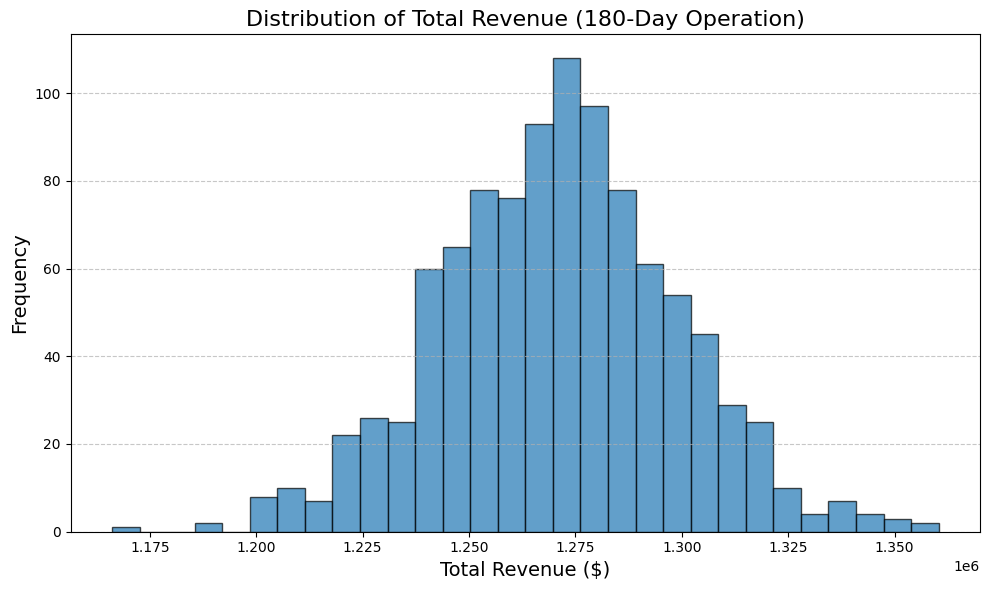

In [28]:
total_revenue = np.zeros(num_simulations)

# Loop through simulations and days to calculate total revenue
for sim in range(num_simulations):
    for day in range(T):
        daily_revenue = 0
        for apprentice in range(num_apprentices):
            # Potion-making rate and sale price
            rate = potion_rate[sim, day, apprentice]
            price = sale_price[sim, day, apprentice]
            daily_revenue += rate * price

        # Weekend decision logic
        is_weekend = day % 7 in [5, 6]  # Saturday (5) or Sunday (6)
        if is_weekend:
            if cumulative_revenue[sim, day - 1] >= 800_000:  # Weekend threshold
                daily_revenue -= weekend_cost
            else:
                daily_revenue = 0  # No weekend work

        # Update cumulative revenue
        cumulative_revenue[sim, day] = (
            cumulative_revenue[sim, day - 1] + daily_revenue
            if day > 0
            else daily_revenue
        )

    # Store total revenue for each simulation
    total_revenue[sim] = cumulative_revenue[sim, -1]

# Plot the distribution of total revenue for T = 180
plt.figure(figsize=(10, 6))
plt.hist(total_revenue, bins=30, edgecolor="k", alpha=0.7)
plt.title("Distribution of Total Revenue (180-Day Operation)", fontsize=16)
plt.xlabel("Total Revenue ($)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
